In [3]:
"""
    Attempts for correlating factors of winning
    1. Understading playing style according a match outcome
    2. Finding correlation on current league"""

'\n    Attempts for correlating factors of winning\n    1. Understading playing style according a match outcome\n    2. Finding correlation on current league\n'

In [155]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [207]:
class Attr:
    def __init__(self, name, value, color=None):
        self.name = name
        self.value = value
        self.color = color

In [208]:
def get_value(attr):
    return attr.value

In [209]:
def sorted_class(names, values, color=None):
    attrs = []
    for i in range(0, len(names)):
        attrs.append(Attr(names[i], values[i]))
    attrs.sort(key=get_value)
    new_names = []
    new_values = []
    for i in range(0, len(names)):
        new_names.append(attrs[i].name)
        new_values.append(attrs[i].value)
    return new_names, new_values

In [156]:
# Set win as 1, draw as 0 and lose as -1
def get_status(r):
    goals_home = r["goals_home"]
    goals_away = r["goals_away"]
    if goals_home > goals_away:
        return 1
    elif goals_home == goals_away:
        return 0
    else:
        return -1

In [157]:
def get_target(df):
    # status_home: either win, draw or lose for home team, predicted label
    target = []
    for index, row in df.iterrows():
        target.append(get_status(row))
    return target

In [158]:
def pass_nan(pass_percentage):
    if pass_percentage == "0.0":
        return "50%"
    else:
        return pass_percentage

In [159]:
def clean_data(df):
    df = df.drop(df.columns[0], axis=1)
    df = df.drop(columns=["league","season","id"], axis=1)
    # Just fixtures statistics
    df = df.drop(df.filter(regex='team_away').columns, axis=1)
    df = df.drop(df.filter(regex='team_home.').columns, axis=1)
    df["stats_away.p_percentage"] = df["stats_away.p_percentage"].apply(pass_nan)
    df["stats_home.p_percentage"] = df["stats_home.p_percentage"].apply(pass_nan)
    # None values set to 0
    df.fillna(value=0, inplace=True)
    # Posession % to decimal as p_percentage
    df["stats_away.p_percentage"] = df["stats_away.p_percentage"].apply(lambda x: (int(str(x).strip('%'))/100))
    df["stats_home.p_percentage"] = df["stats_home.p_percentage"].apply(lambda x: (int(str(x).strip('%'))/100))
    df["stats_away.possession"] = df["stats_away.possession"].apply(lambda x: (int(str(x).strip('%'))/100))
    df["stats_home.possession"] = df["stats_home.possession"].apply(lambda x: (int(str(x).strip('%'))/100))
    return df

In [160]:
def df_season(country, league, season, week):
    dirCountry = '../' + country + '/'
    dirName = dirCountry + league + '/' + str(season) + '/'
    file_title = str(season) + '_' + str(week) + '.csv'
    csv_file = dirName + file_title
    df = pd.read_csv(csv_file)
    df = clean_data(df)
    target = get_target(df)
    df = df.drop(columns=["goals_away","goals_home"], axis=1) 
    return df, target

In [161]:
def group_targets(target):
    wins_home = 0
    draws = 0
    loses_home = 0
    for label in target:
        if label == 1:
            wins_home = wins_home + 1
        elif label == 0:
            draws = draws + 1
        elif label == -1:
            loses_home = loses_home + 1
    x = ['wins_home', 'draws', 'loses_home']
    y = [wins_home, draws, loses_home]
    return x, y

In [162]:
def bar_graph(axs, row, column, y, x_label, y_label):
    axs[row, column].bar(x_label, y)
    axs[row, column].set_title(y_label)
    for i in range(len(x_label)):
        axs[row, column].annotate(str(y[i]), xy=(x_label[i], y[i]))
    return axs

In [213]:
def weights_graph(axs, row, season, model, val, rmse, r_sq, weights, x_label):
    title = str(season) + ' ' + model + ' ' + val
    rmse_txt = "RMSE: " + '{0:.2f}'.format(rmse)
    r_txt = "R^2: " + '{0:.2f}'.format(r_sq)
    x_label, weights = sorted_class(x_label, weights)
    axs[row].bar(x_label, weights)
    axs[row].set_title(title)
    axs[row].text(1, 1.1, rmse_txt, color="b", fontsize=10, horizontalalignment='center', verticalalignment='center',
     transform = axs[row].transAxes)
    axs[row].text(1, 1.2, r_txt, color="b", fontsize=10, horizontalalignment='center', verticalalignment='center',
     transform = axs[row].transAxes)
    axs[row].tick_params(axis='x', labelrotation=90)
    for i in range(len(x_label)):
        axs[row].annotate('{0:.2f}'.format(weights[i]), xy=(x_label[i], weights[i]), verticalalignment='bottom')
    return axs

In [239]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_squared_error, r2_score

In [255]:
def ols_ridge(season, data, target, test_len=None, cross_val=None):
    r = 2
    fig, axs = plt.subplots(r)
    fig.set_size_inches(18.5, 10.5)
    # Create index mat
    mat = [j for j in range(0, r)]
    i = 0
    
    x_label = data.columns
    if test_len != None:
        X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=test_len, random_state=0)
    classifiers = dict(ols=linear_model.LinearRegression(), ridge=linear_model.Ridge(alpha=.1))
    
    for name, clf in classifiers.items():
        if cross_val != None:
            clf_mse = cross_validate(clf, data, target, cv=cross_val, scoring=('r2', 'neg_mean_squared_error'), return_train_score=True, return_estimator=True)
            mse_sqr = np.sqrt(clf_mse['test_neg_mean_squared_error'].mean()*-1)
            mse_r = np.sqrt(clf_mse['test_r2'].mean())
            coef = []
            for model in clf_mse['estimator']:
                coef.append(model.coef_)
            final_coef = np.matrix(coef)
            final_coef = final_coef.mean(0)
            final_coef = np.array(final_coef).flatten()
            axs = weights_graph(axs, mat[i], season, name, "cv-5", mse_sqr, mse_r, final_coef, x_label)
        else:
            clf.fit(X_train, y_train)
            Y = clf.predict(X_test)
            mse = mean_squared_error(y_test, Y)
            axs = weights_graph(axs, mat[i], season, name, "train-test", np.sqrt(mse), clf.score(X_test, y_test), clf.coef_, x_label)
        i = i + 1
    
    fig.tight_layout()
    plt.show()

In [263]:
def mod_target(target):
    new_target = []
    for label in target:
        if label != 1:
            new_target.append(0)
        else:
            new_target.append(1)
    return new_target

In [282]:
def draw_vs_loss(data, target):
    new_data =[]
    new_target = []
    i = 0
    for index, row in data.iterrows():
        current_target = target[i]
        i = i + 1
        if current_target == 1:
            continue
        elif current_target == 0:
            current_target = 1
        elif current_target == -1:
            current_target = 0
        new_data.append(row.values)
        new_target.append(current_target)
    df_new = pd.DataFrame(new_data, columns=data.columns)
    return df_new, new_target

In [163]:
# League directory
country = 'ES'
league = '140'
curr_week = 38

In [164]:
# Historicity: multi season directory
year_window = 4
start_season = 2019
seasons = list(range(start_season, start_season - year_window, -1))
print(seasons)

[2019, 2018, 2017, 2016]


In [165]:
# Data initialization
data = []
for season in seasons:
    df, target = df_season(country, league, season, curr_week)
    tup = (season, df, target)
    data.append(tup)

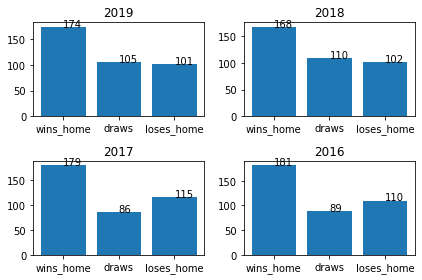

In [166]:
# Labels balance
r = 2
c = 2
fig, axs = plt.subplots(r, c)
# Create index mat
mat = [[i,j] for i in range(0, r) for j in range(0, c)]
i = 0
for d in data:
    # d[2] is the target
    x, y = group_targets(d[2])
    axs = bar_graph(axs, mat[i][0], mat[i][1], y, x, d[0])
    i = i + 1
fig.tight_layout()
plt.show()

In [167]:
"""
    Feature relevance between wins, draws and loses
"""

'\n    Feature relevance between wins, draws and loses\n'

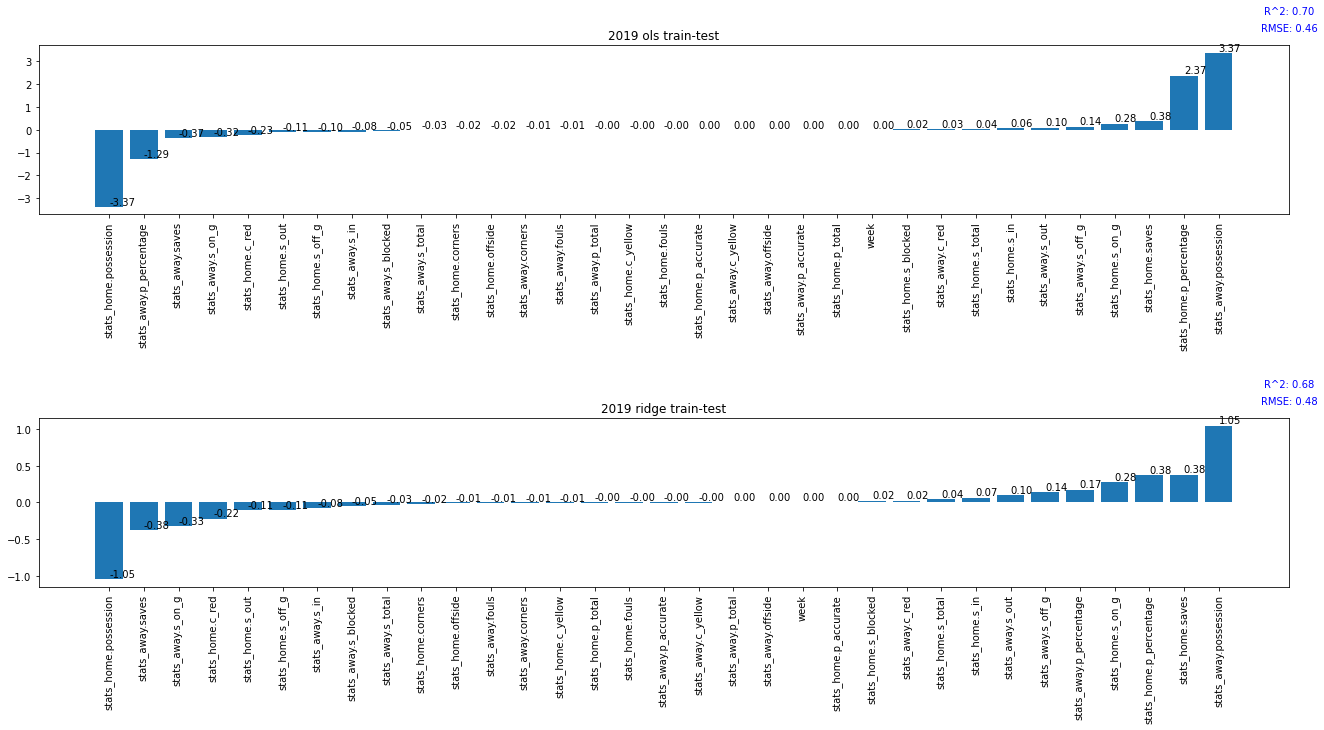

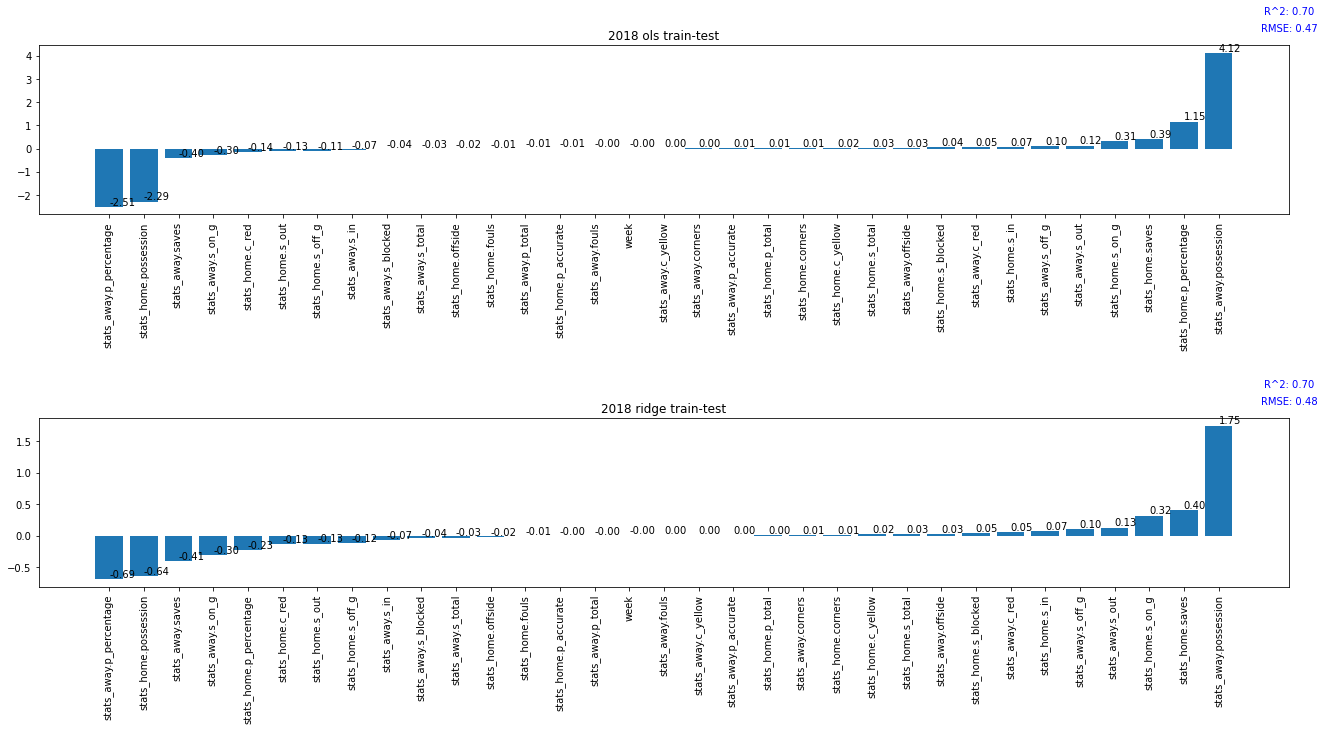

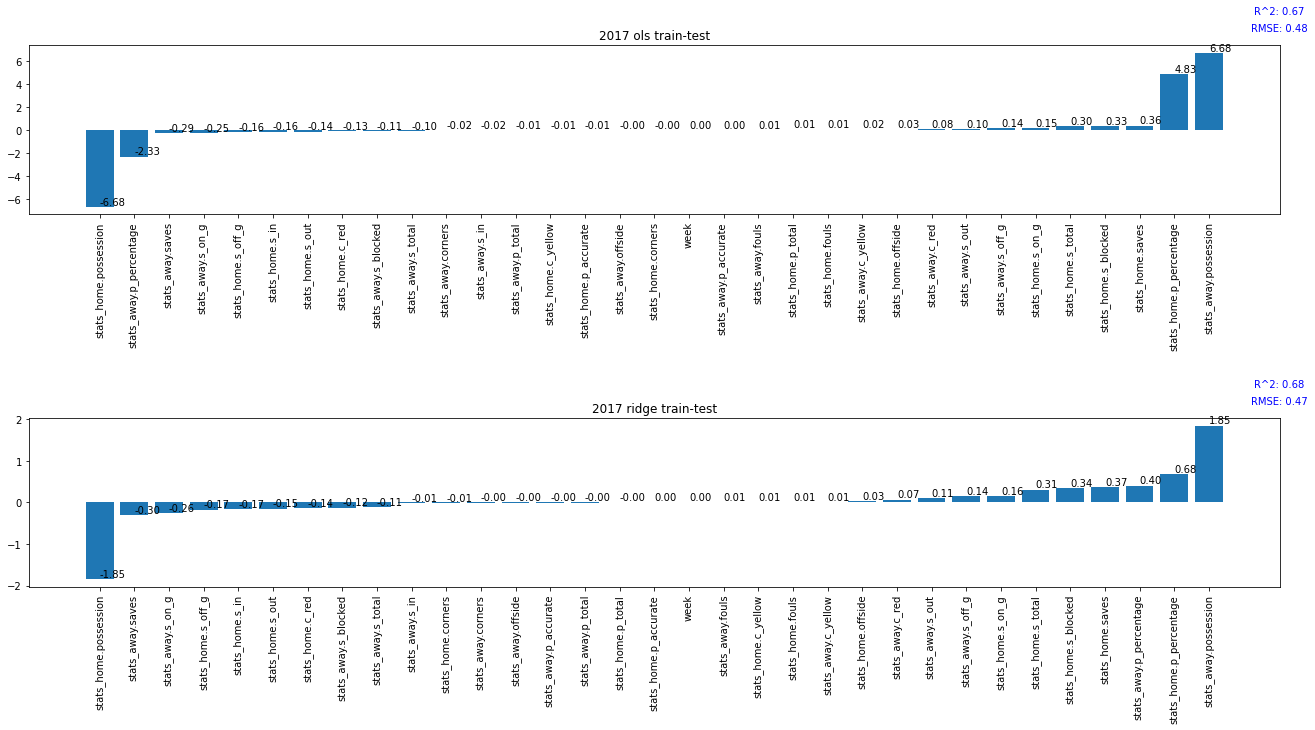

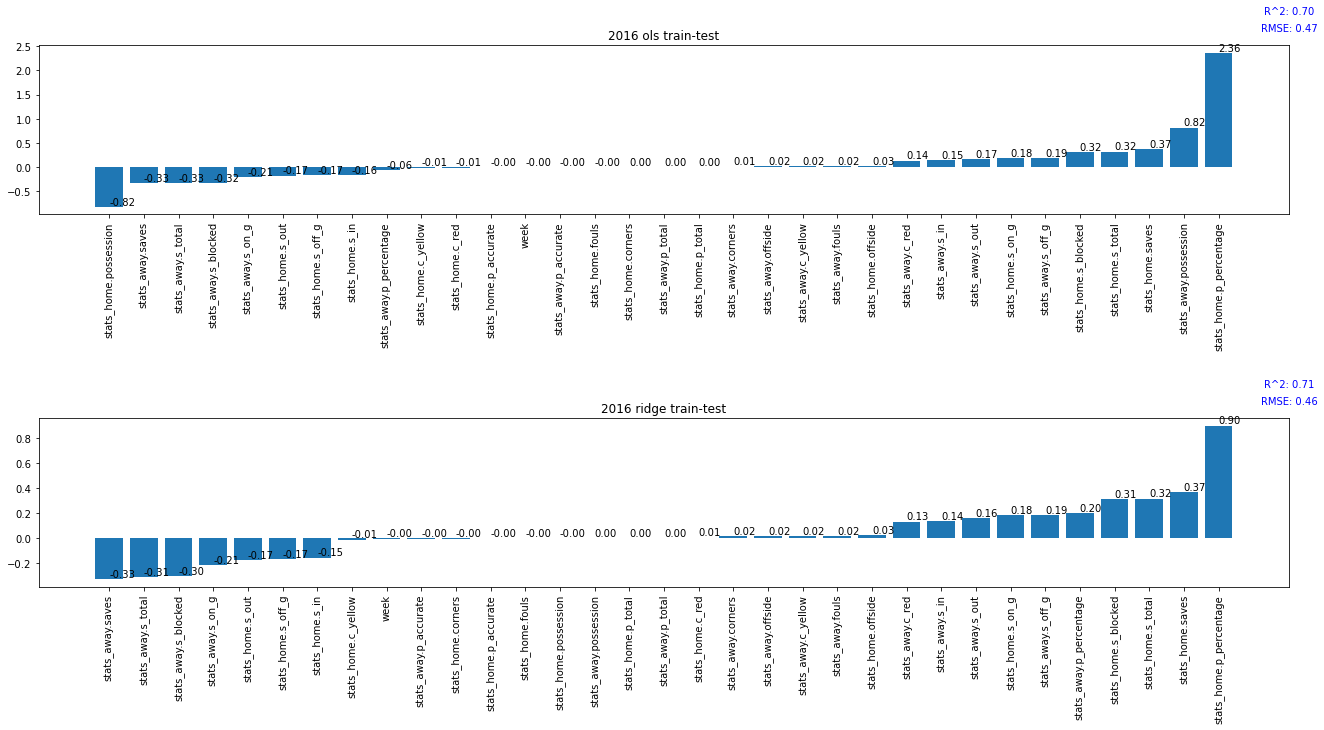

In [249]:
for d in data:
    ols_ridge(d[0], d[1], d[2], test_len = 0.2)

In [250]:
"""
    Here we have a dataset with the 4 years together
"""
all_data = pd.DataFrame()
all_target = []
for d in data:
    all_data = all_data.append(d[1])
    all_target = all_target + d[2]

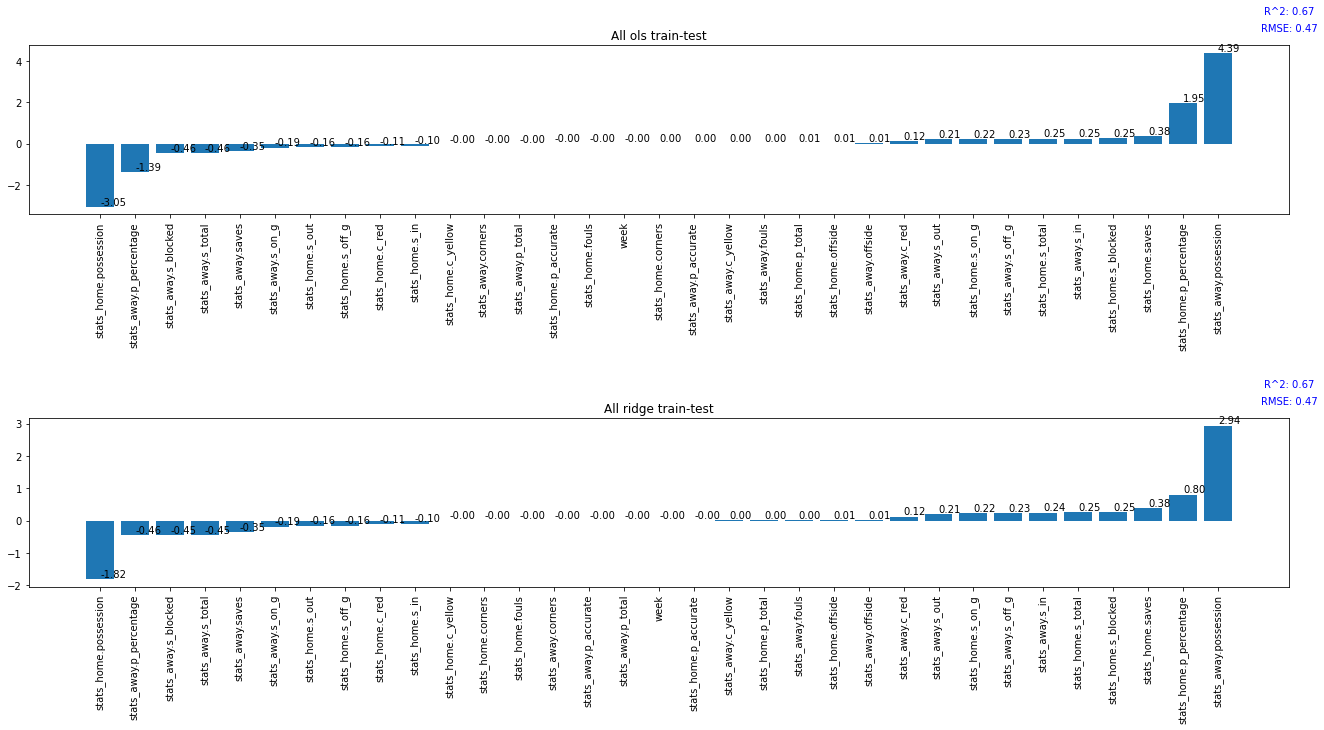

In [251]:
# All data
ols_ridge("All", all_data, all_target, test_len = 0.2)

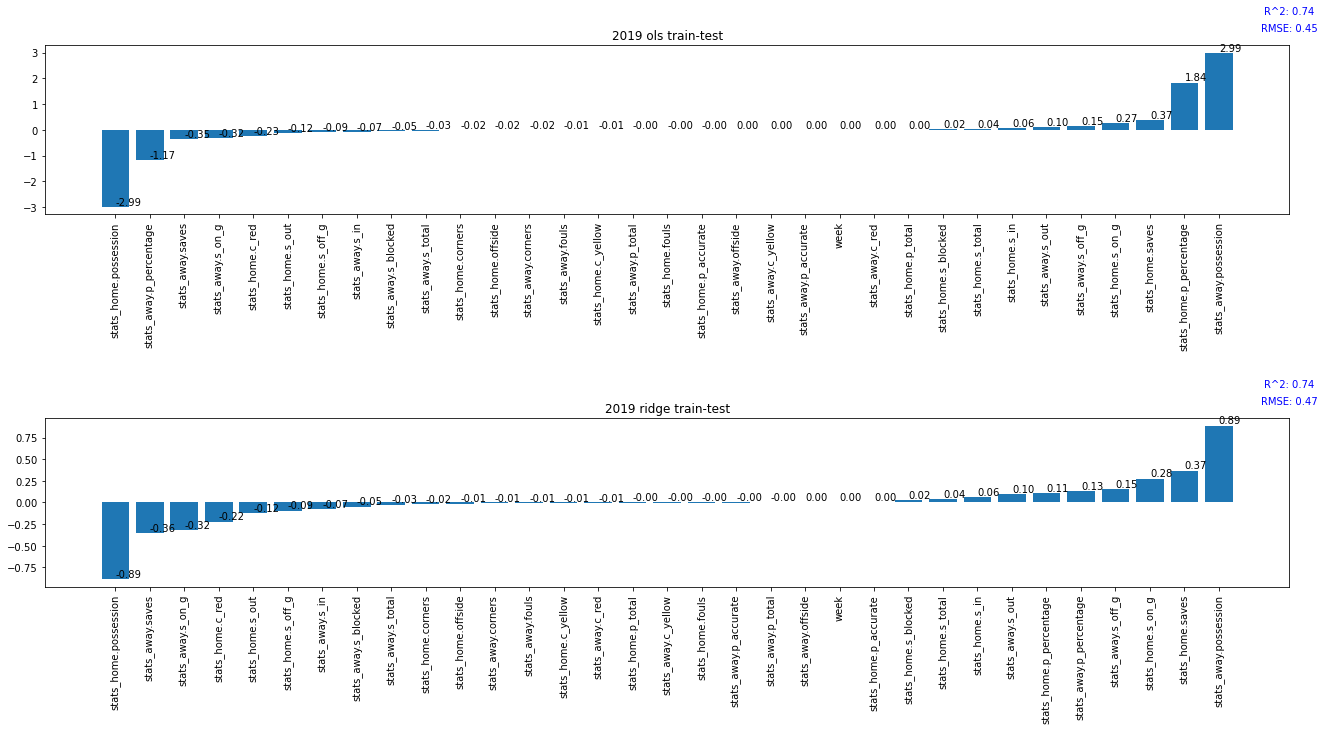

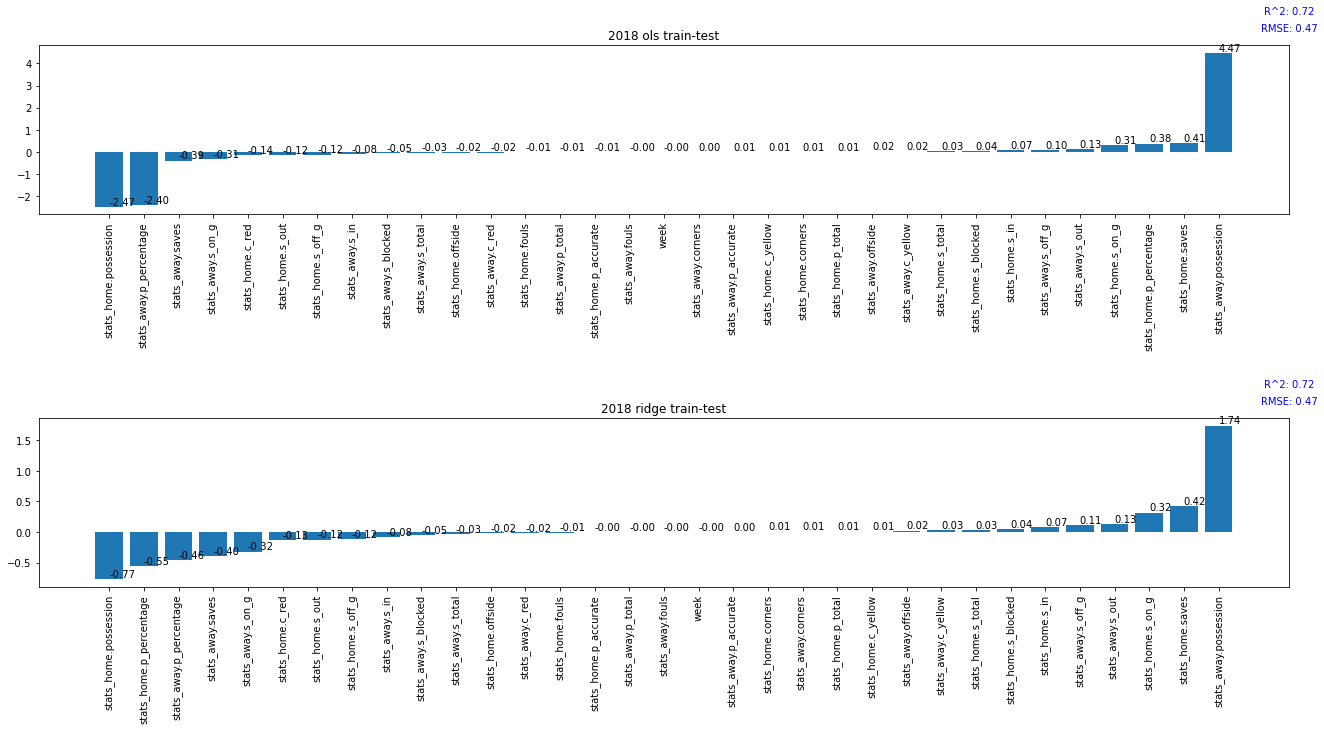

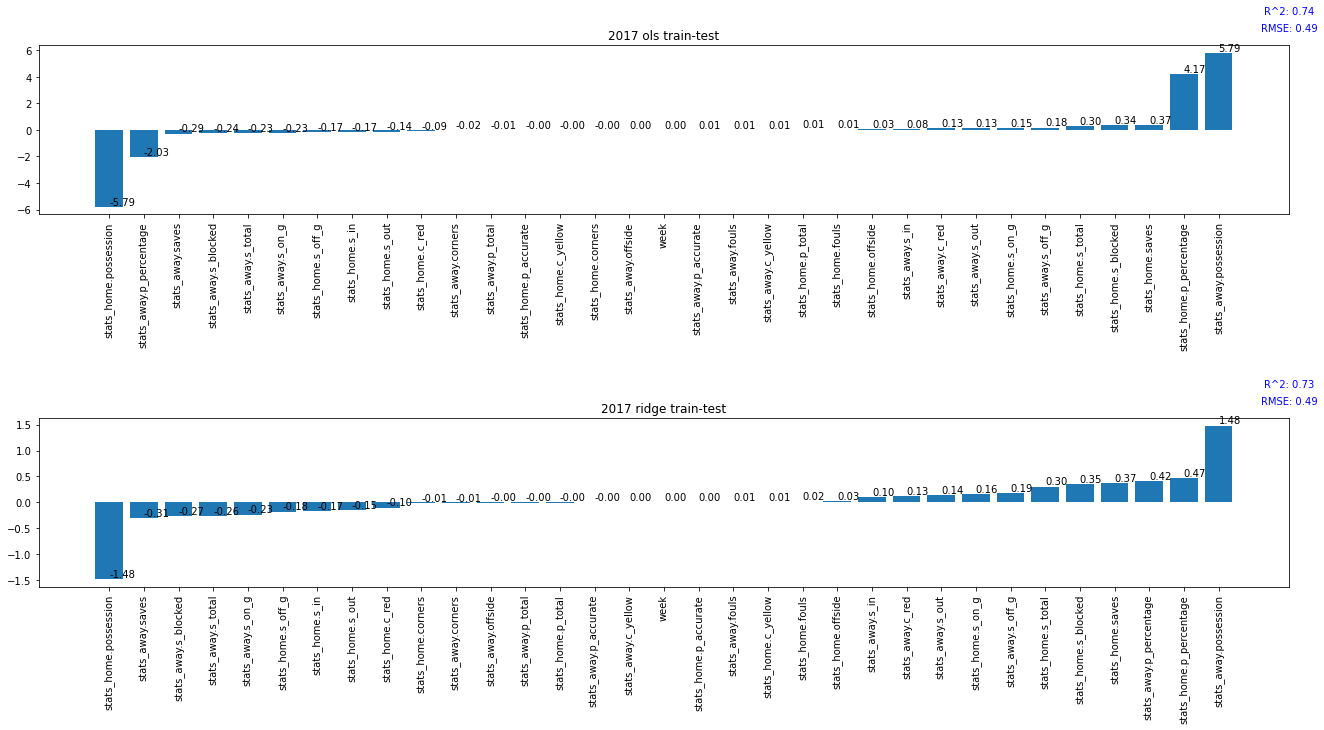

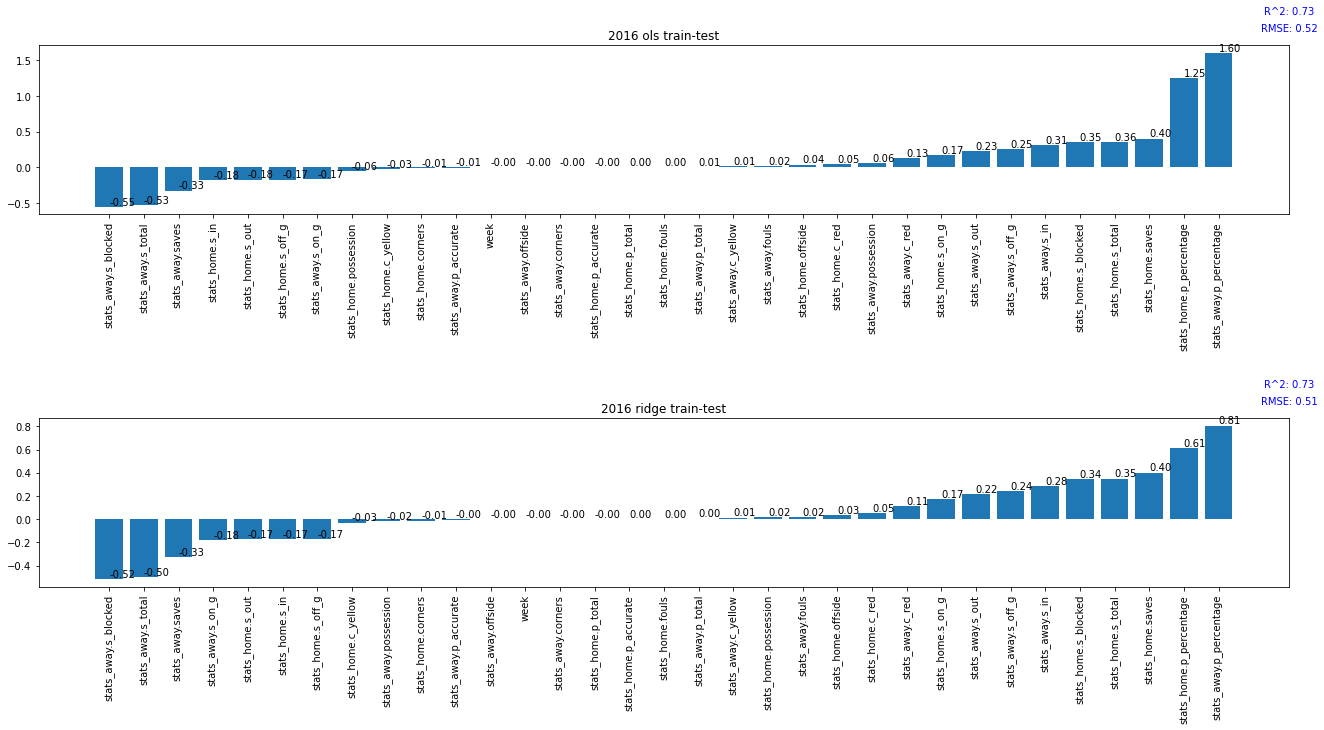

In [216]:
# OLS vs ridge from 2019 to 2016
# Training 70/30
for d in data:
    ols_ridge(d[0], d[1], d[2], test_len = 0.3)

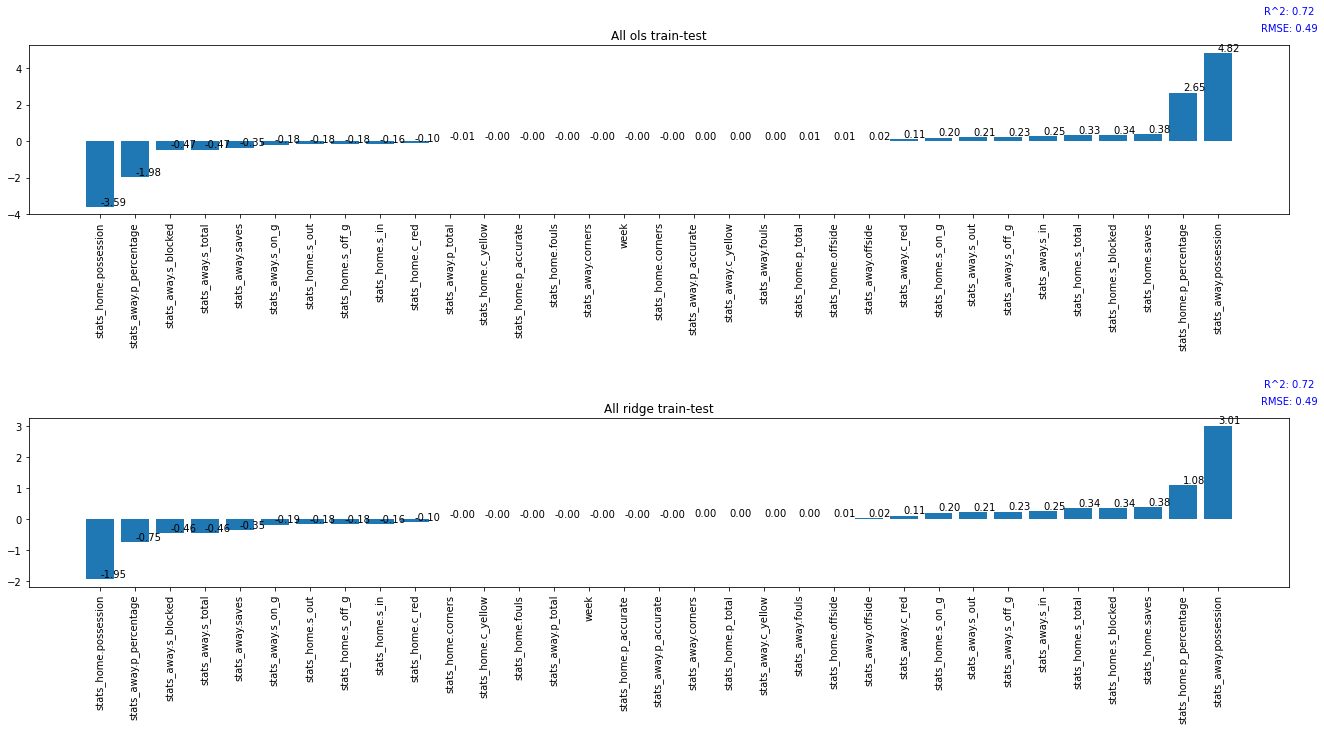

In [226]:
# All data
ols_ridge("All", all_data, all_target, test_len = 0.3)

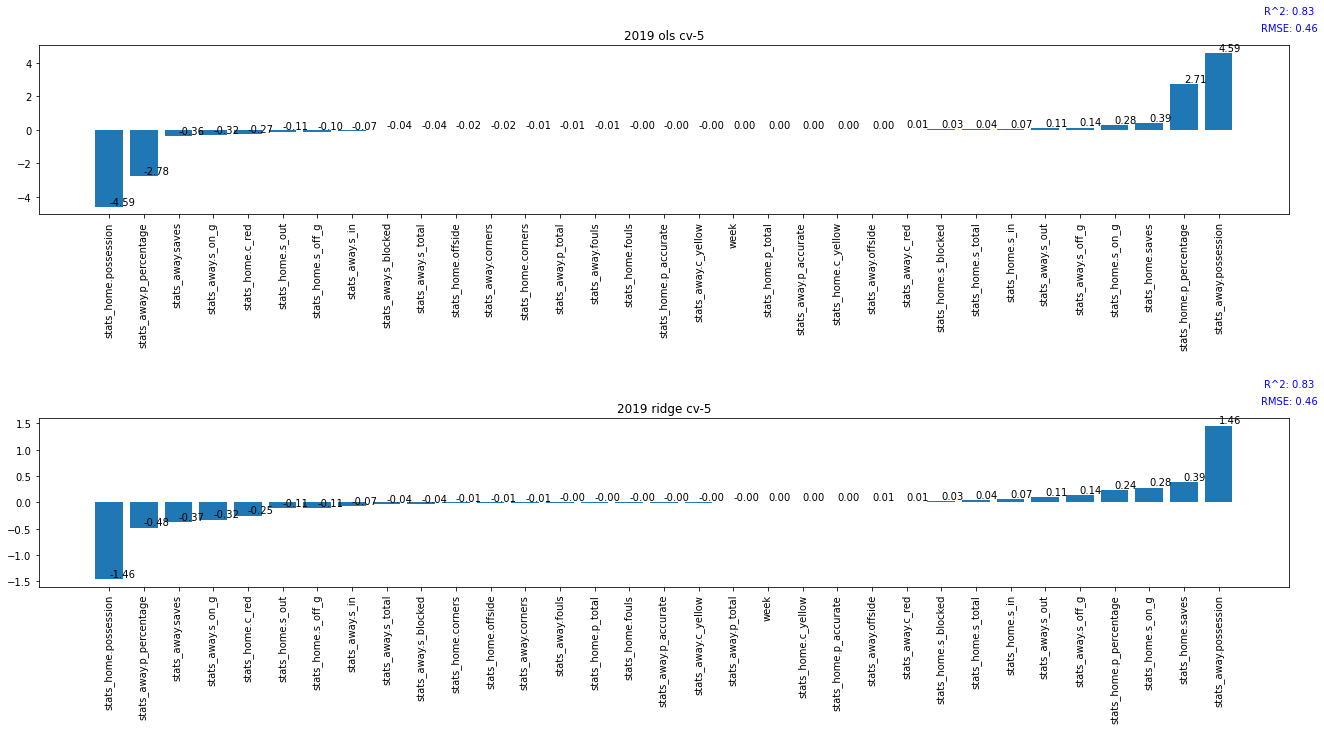

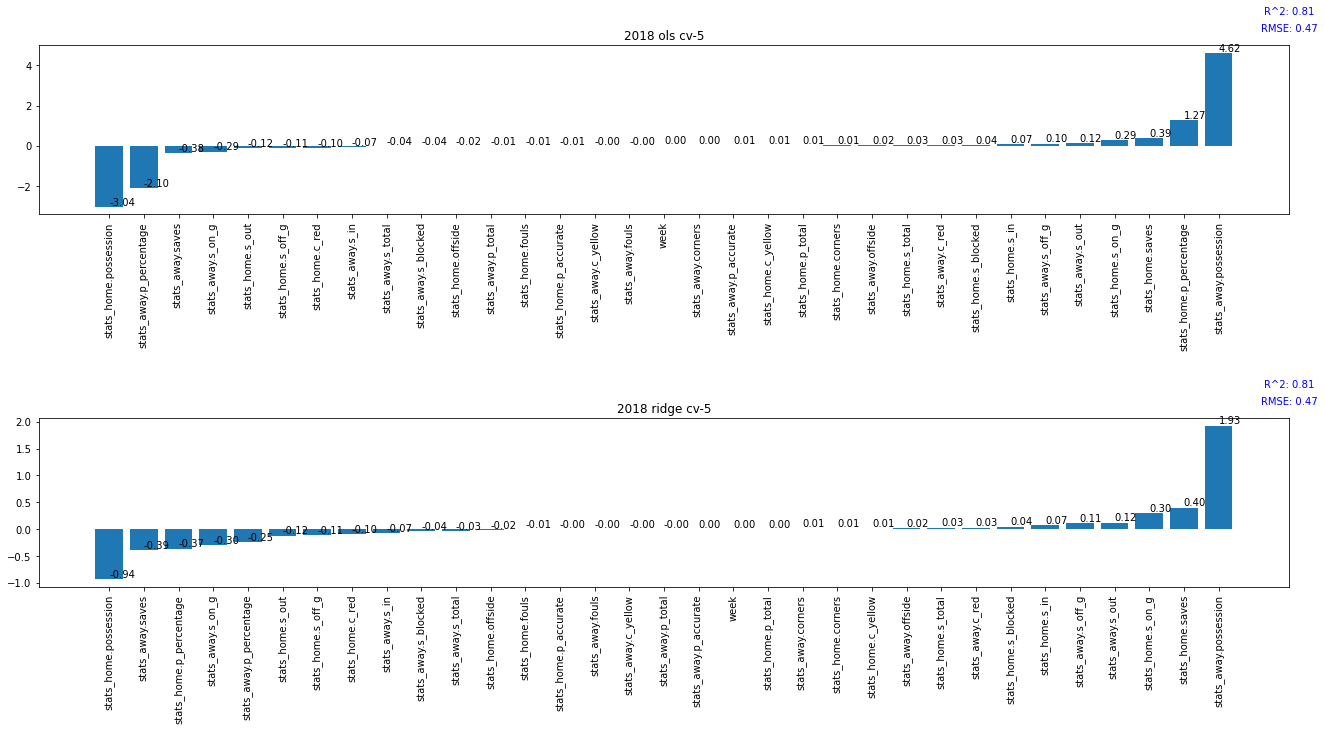

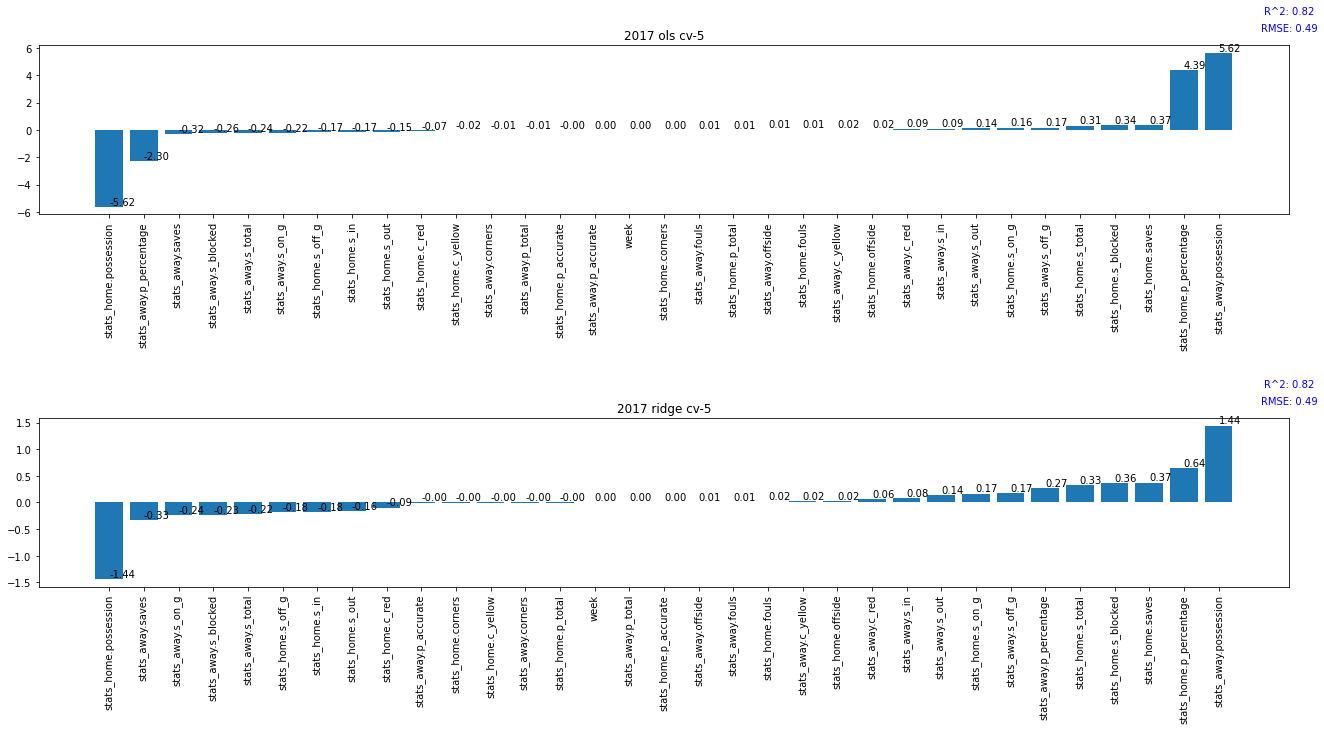

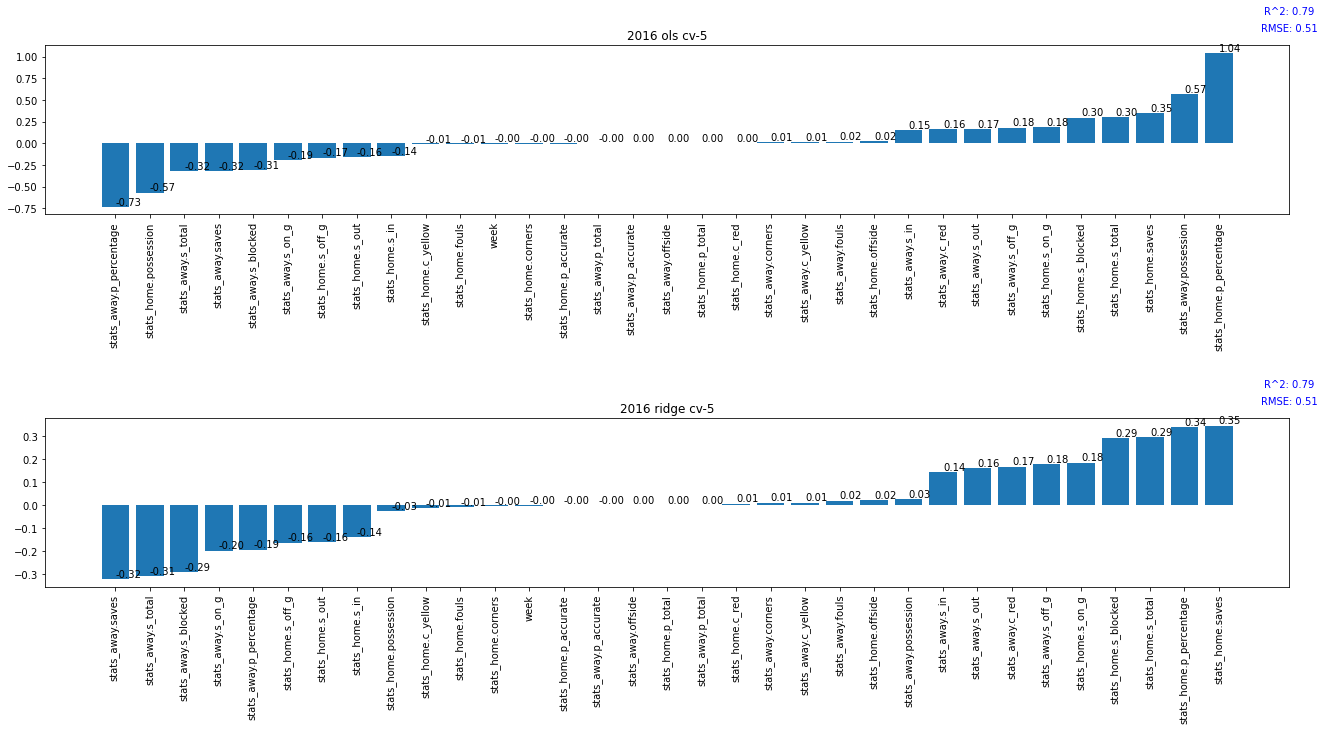

In [256]:
# OLS vs ridge from 2019 to 2016
# CV
for d in data:
    ols_ridge(d[0], d[1], d[2], cross_val=5)

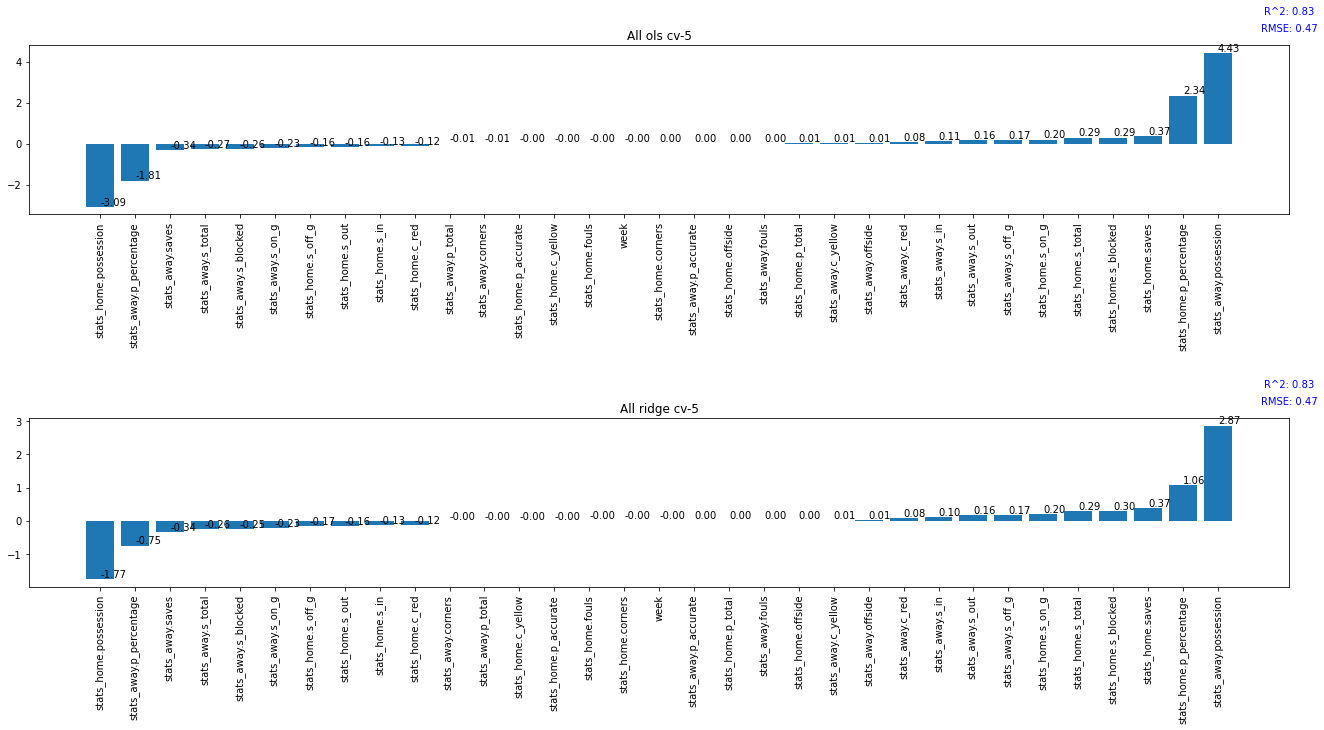

In [257]:
# All data
ols_ridge("All", all_data, all_target, cross_val=5)

In [ ]:
"""
    Feature relevance between what is a win and not a win (either draw or loss)
"""

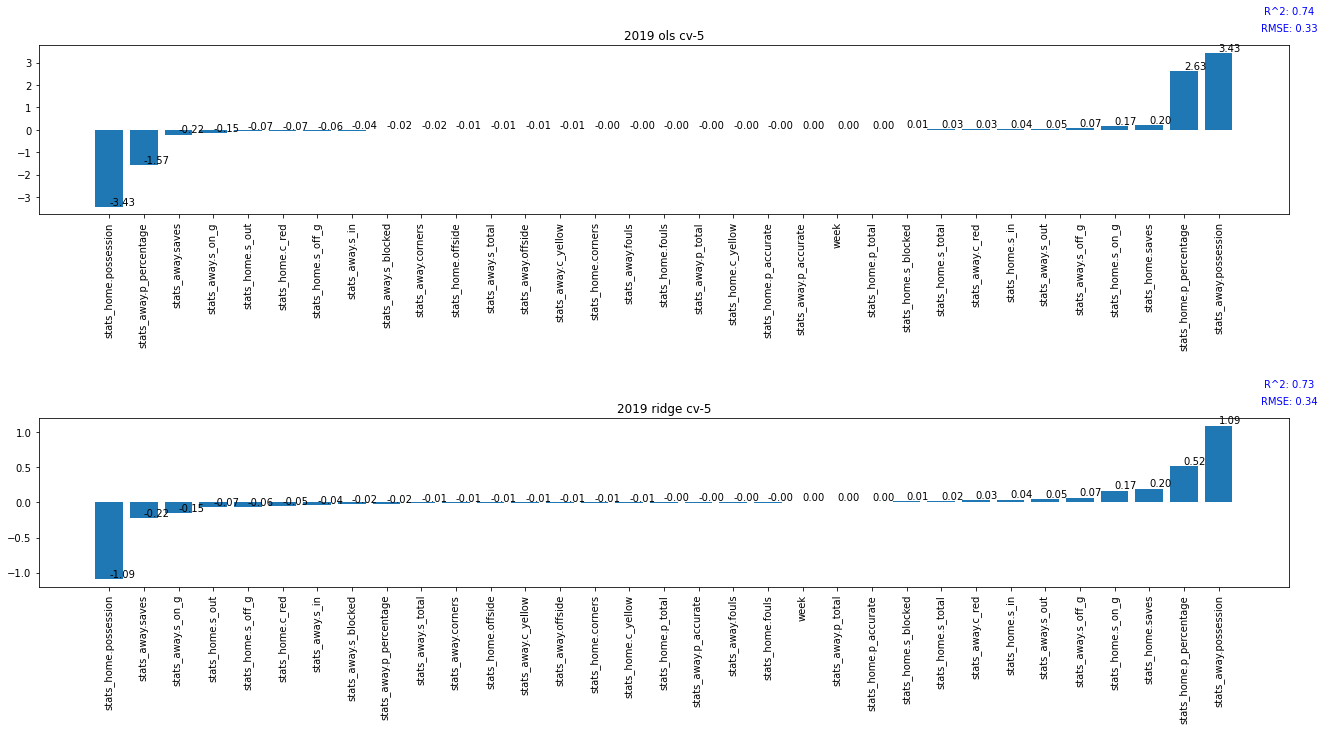

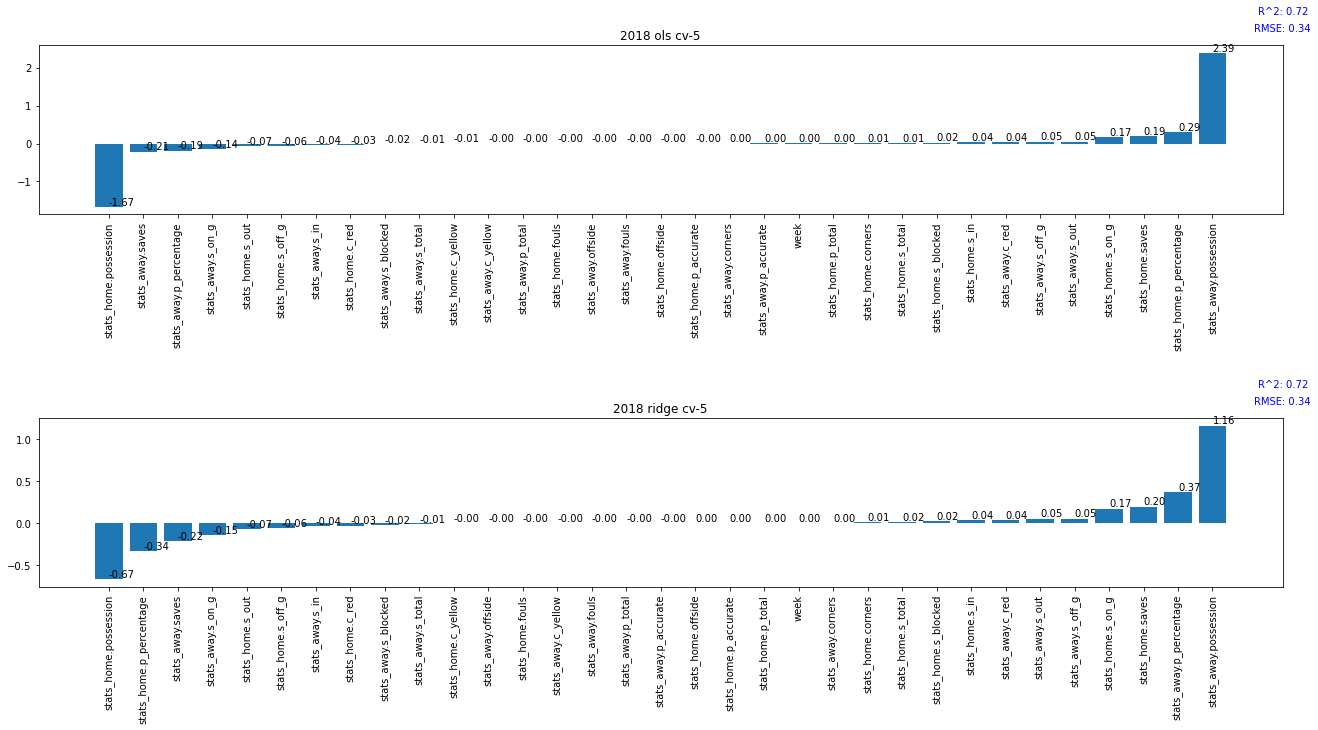

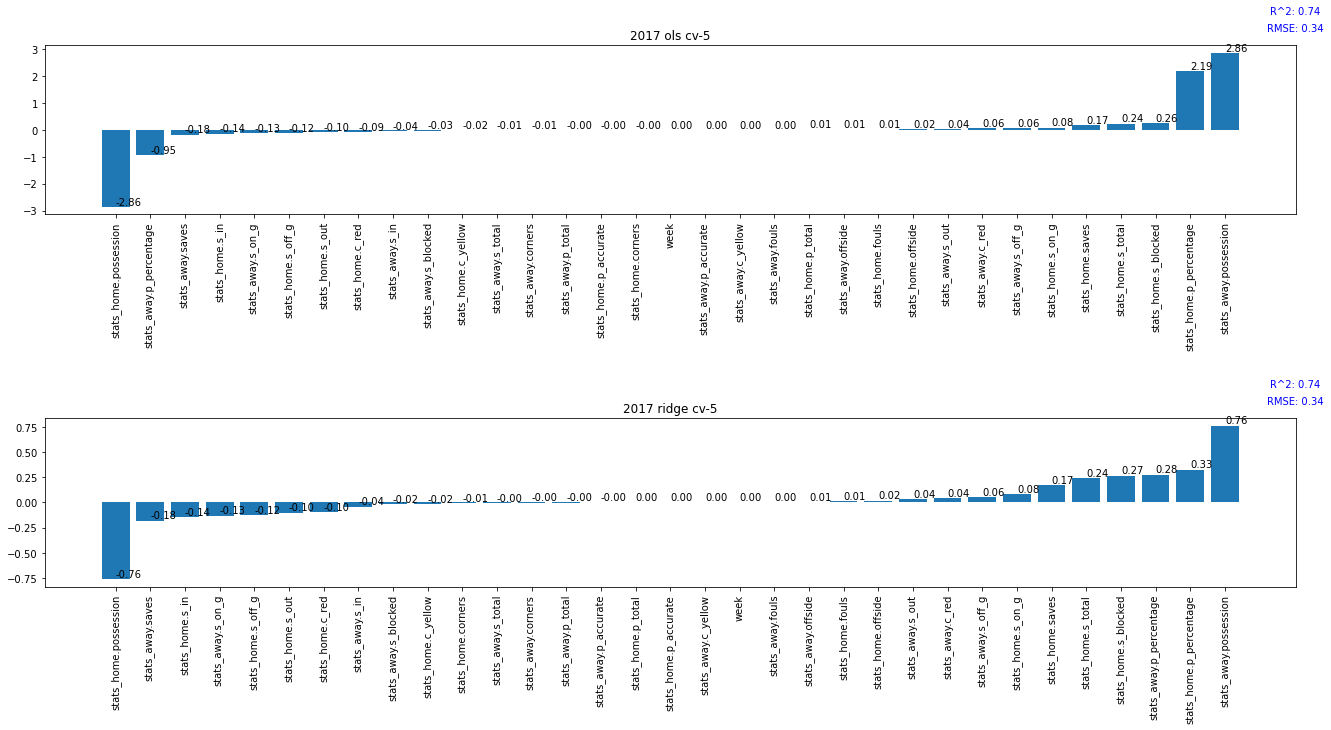

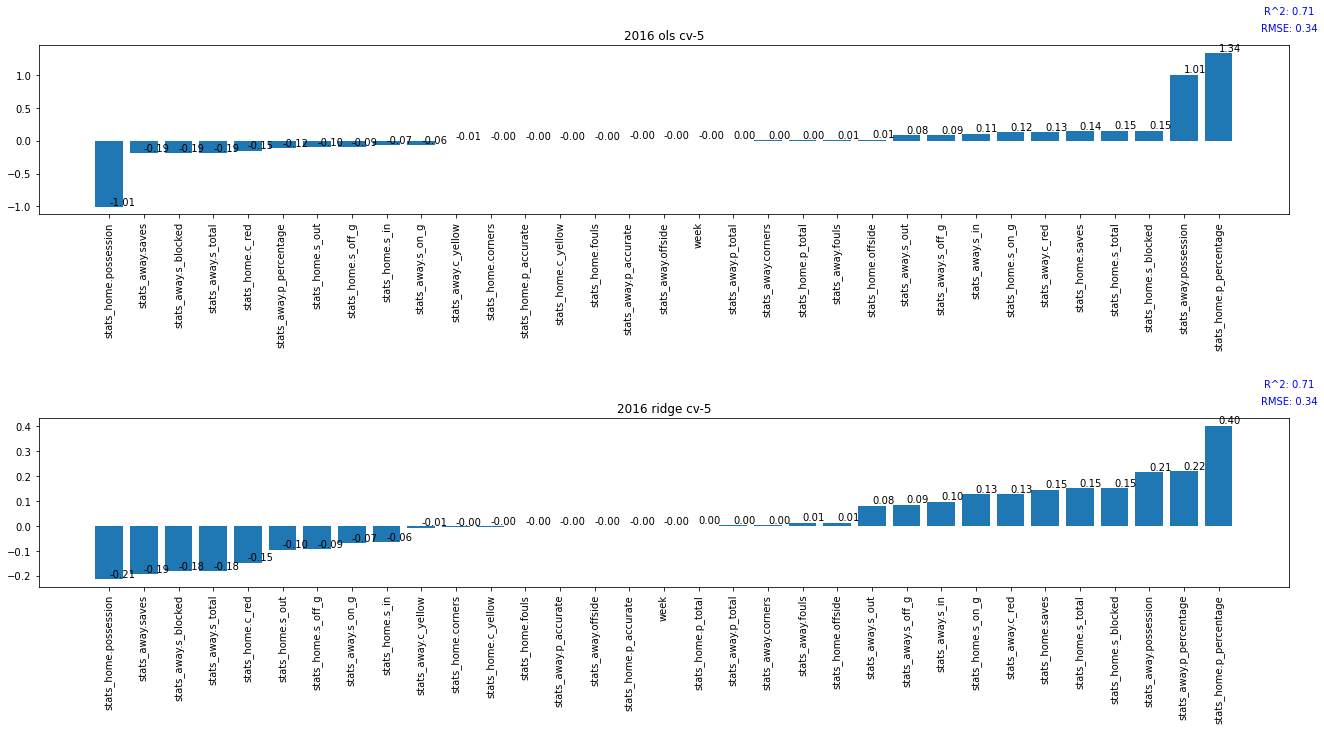

In [284]:
# Labels as 1 for home_win, 0 else
for d in data:
    new_target = mod_target(d[2])
    ols_ridge(d[0], d[1], new_target, cross_val = 5)

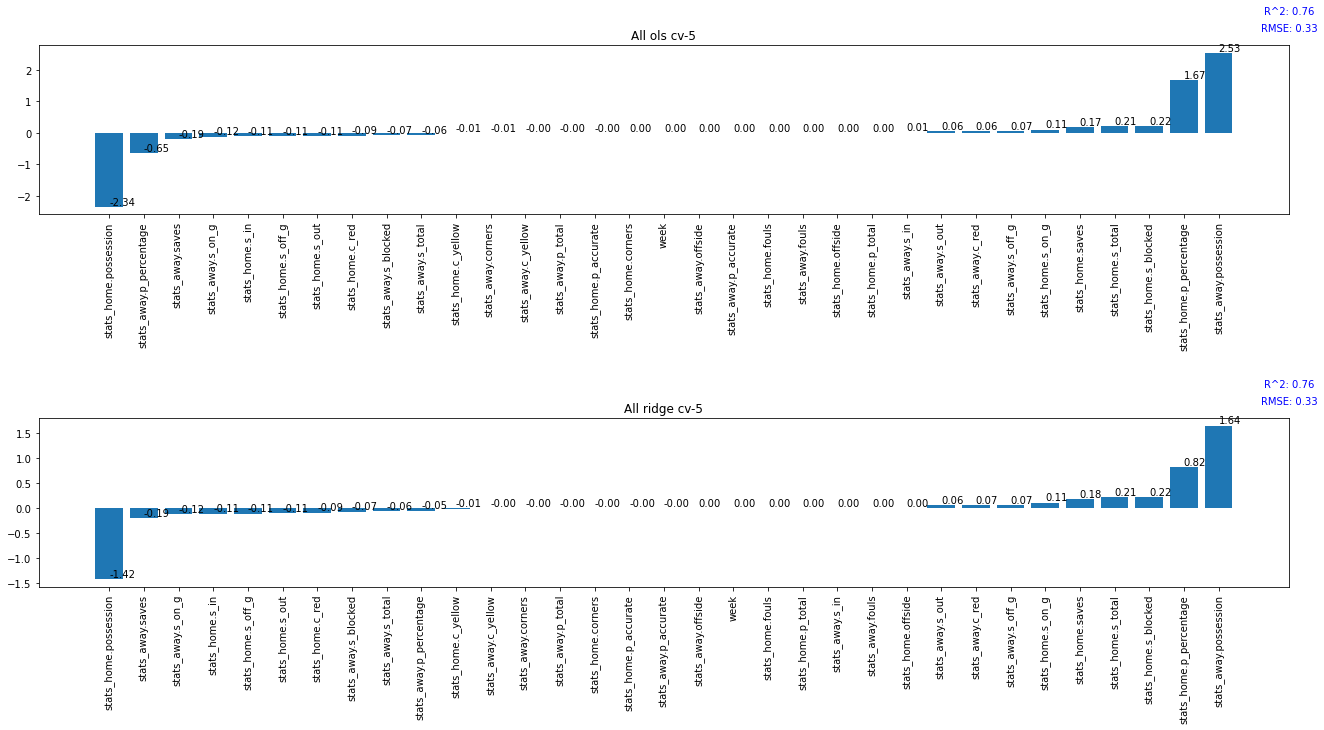

In [285]:
# All data
new_target = mod_target(all_target)
ols_ridge("All", all_data, new_target, cross_val = 5)

In [ ]:
"""
    Distinguish between a draw or loss
"""

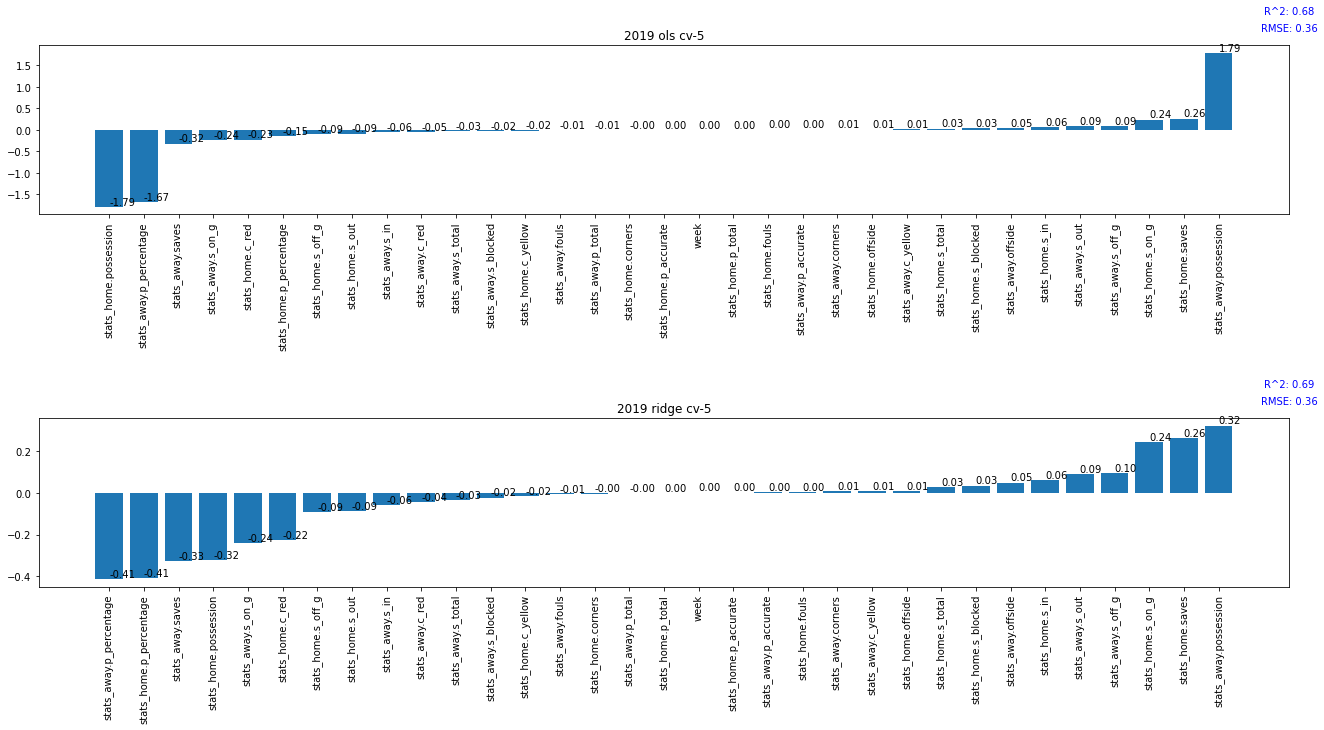

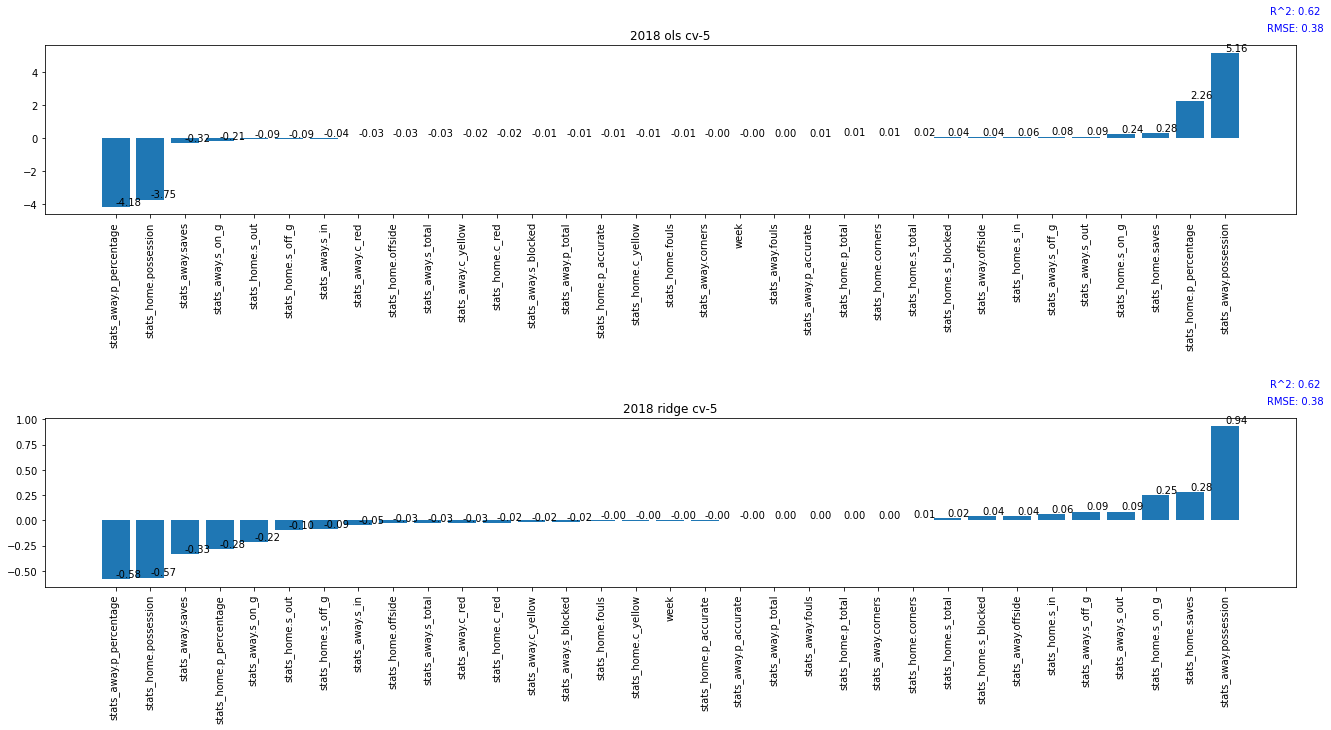

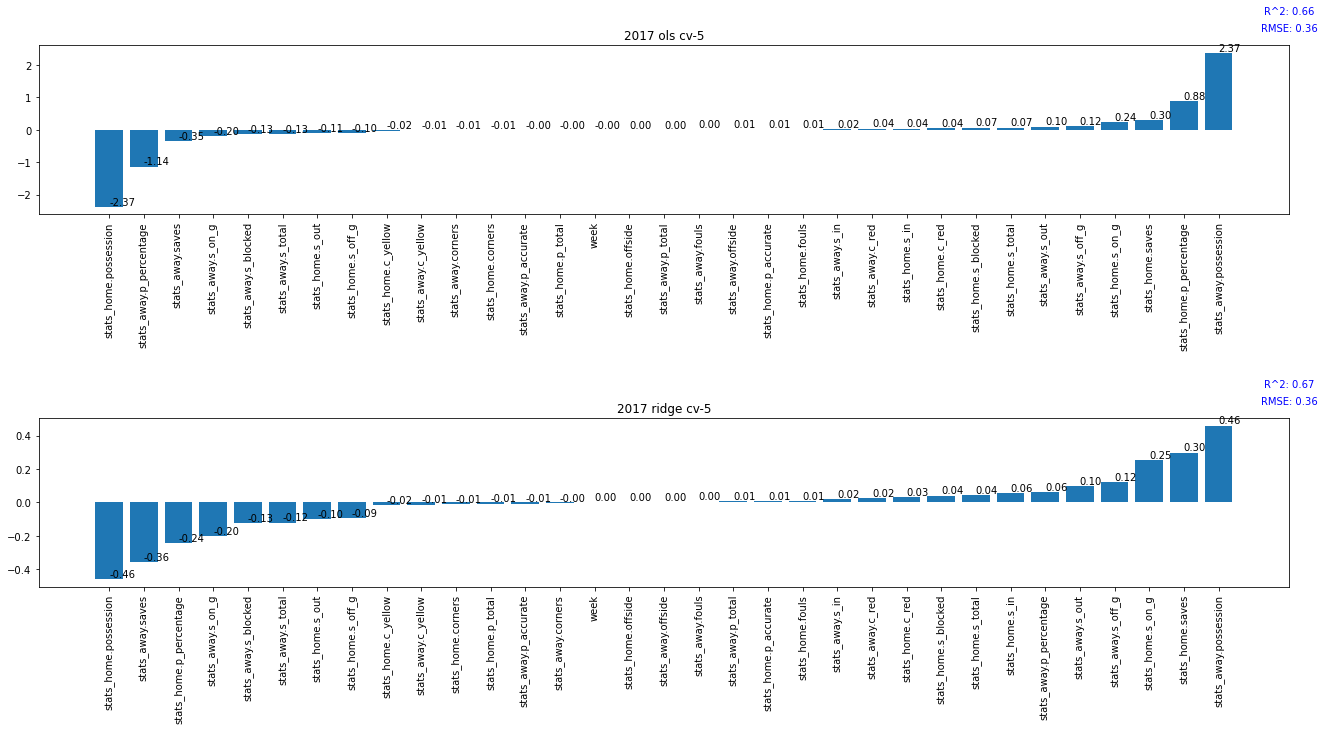

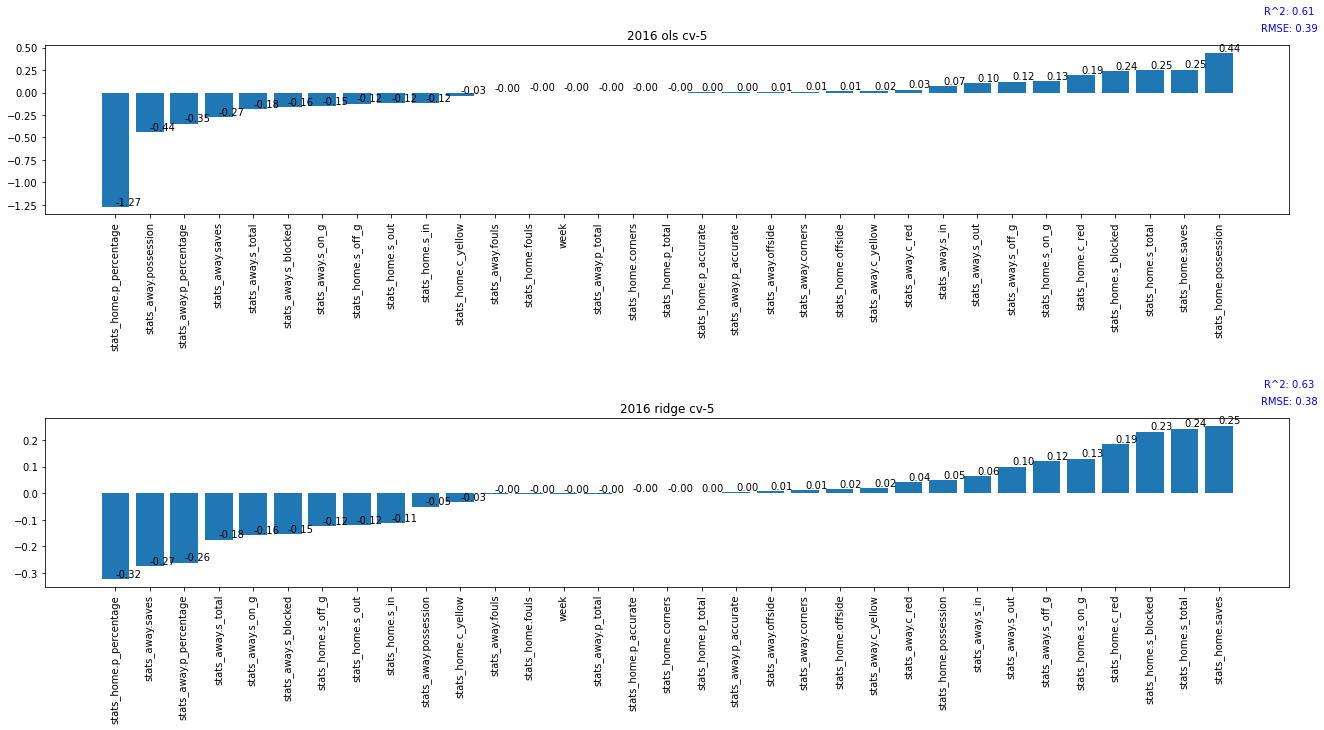

In [283]:
# Labels as 1 for home_win, 0 else
for d in data:
    new_data, new_target = draw_vs_loss(d[1], d[2])
    ols_ridge(d[0], new_data, new_target, cross_val = 5)

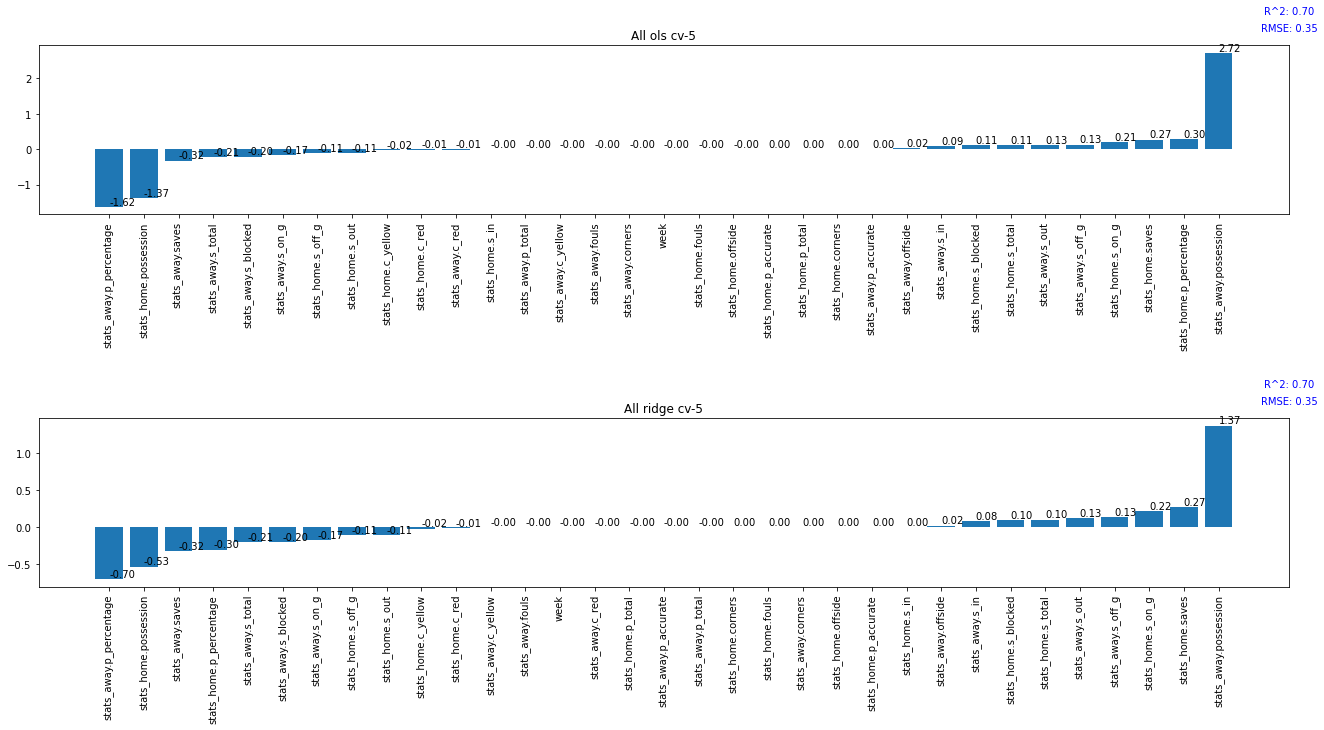

In [286]:
# All data
new_data, new_target = draw_vs_loss(all_data, all_target)
ols_ridge("All", new_data, new_target, cross_val = 5)